# Modelo: Red Neuronal

El modelo a entrenar en el siguiente notebook se tratará de una red neuronal. Por el tipo de modelo del que se trata, iremos mostrando la serie de pasos y decisiones hasta llegar a los hiperparámetros y estructura de la red final, en lugar de realizar dicha busqueda con GridSearch o técnicas similares. Por una cuestión de no extenderse demasiado, buscaremos sintetizar el camino pero intentando mostrar los problemas que surgieron

##  Librerias y funciones necesarias

Para comenzar importamos las librerias que utilizaremos. En este caso para la construcción de la red utilizaremos la libreria Keras y para evaluar las metricas utilizaremos Sklearn. Luego importamos las funciones necesarias para los preprocesamientos

In [62]:
import pandas
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import numpy as np
import tensorflow.keras.optimizers
import tensorflow.keras.metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from keras.regularizers import l2,l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, roc_auc_score
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica
from preprocessing import conversion_numerica_generalizada
from preprocessing import plot_roc_curves_red
from preprocessing import graficar_matriz_confusion

Para lograr tener la misma salida realizamos lo siguiente. Es valido aclarar que esto genera la misma salida en la misma cpu, al cambiar, en nuestra experiencia genero salidas parecidas pero podria no suceder. La idea de esto es poder reproducir siempre los mismos resultados si se corre de nuevo el notebook. En ocasiones observamos bastante diferencia según se elija una seed u otra. 

In [ ]:
from numpy.random import seed
seed(0)
import tensorflow.random
tensorflow.random.set_seed(0)


## Primer preprocesamiento

En primer lugar obtenemos el dataset para entrenar y el holdout. En segundo lugar, aplicamos una función que trabaja sobre las features, generalizando algunas y dejando de lado otras según lo observado en la primer parte de este trabajo práctico. También separamos a la variable target del resto del dataset. Por último, convertimos a númericas las variables categoricas para poder entrenar nuestro modelo

In [3]:
df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df) 

Aplicando 'conversion_numerica' en las variables categóricas.


Luego vamos a realizar un split del dataset para dividir en train y test. Como observamos en la primer parte de este trabajo práctico, la variable target no esta distribuida uniformente por lo cual realizamos una división estratificada

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=30,stratify=y_df)

### Primer diseño de la red

#### Diseño y entrenamiento

Comenzaremos con una red simple de una capa de 4 neuronas con función de activación Tanh y una ultima capa de una neurona con función de activación Sigmoidea. Esta última capa se repetirá en todas nuestras redes a construir. También se repetirá nuestra función de perdida (binary_crossentropy) y las métricas para evaluar que serán AUC y accuracy. Comenzaremos con SGD como primer optimizador, cuyo larning rate por default es 0.01

In [5]:
model = Sequential()
model.add(Dense(4,input_shape = (40,),activation='tanh'))
model.add(Dense(1, activation="sigmoid"))

Compilamos nuestro primer modelo y observamos un resumen de su composición

In [6]:
auc_ = tensorflow.keras.metrics.AUC(num_thresholds=200)
model.compile(loss='binary_crossentropy', optimizer='SGD',metrics=[auc_,'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 164       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


Ahora si, realicemos nuestro primer entrenamiento. Primeramente entrenaremos 100 epochs

In [7]:
history = model.fit(X_train.values, y_train,epochs=100,verbose=1,validation_data=(X_test.values, y_test))

Epoch 1/100
814/814 [==============================] - 3s 3ms/step - loss: 0.5590 - auc: 0.5937 - accuracy: 0.7493 - val_loss: 0.5148 - val_auc: 0.6521 - val_accuracy: 0.7778
Epoch 2/100
814/814 [==============================] - 2s 2ms/step - loss: 0.5077 - auc: 0.6510 - accuracy: 0.7823 - val_loss: 0.5110 - val_auc: 0.6514 - val_accuracy: 0.7778
Epoch 3/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4987 - auc: 0.6892 - accuracy: 0.7817 - val_loss: 0.4892 - val_auc: 0.7241 - val_accuracy: 0.7778
Epoch 4/100
814/814 [==============================] - 1s 805us/step - loss: 0.4874 - auc: 0.7122 - accuracy: 0.7836 - val_loss: 0.4821 - val_auc: 0.7274 - val_accuracy: 0.7778
Epoch 5/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4896 - auc: 0.7167 - accuracy: 0.7774 - val_loss: 0.4902 - val_auc: 0.7357 - val_accuracy: 0.7778
Epoch 6/100
814/814 [==============================] - 1s 937us/step - loss: 0.4741 - auc: 0.7324 - accuracy: 0.7846 - val_

#### Métricas

Para evaluar los resultados obtenidos, observaremos la curva de aprendizaje tanto de la accuracy como del AUC

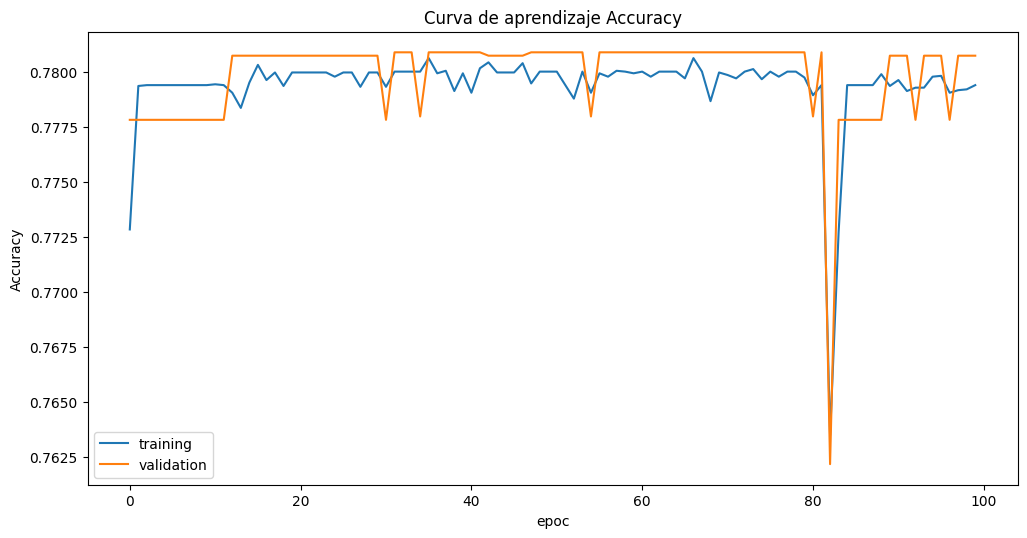

In [8]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.65,0.8,0.025))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

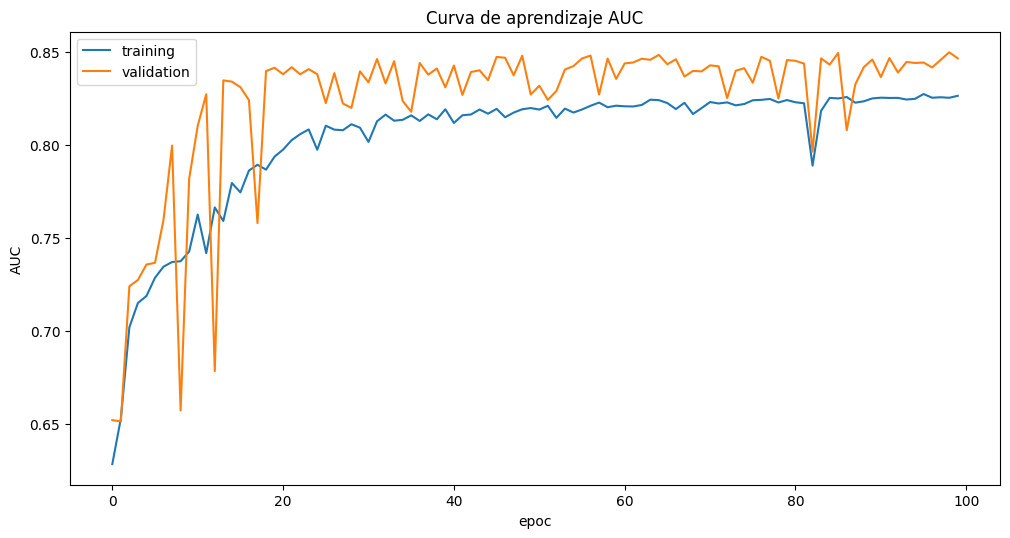

In [9]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

Llegado este punto es importante destacar algunas cosas. En primer lugar, el calculo de AUC provisto por keras tomo una cierta cantidad de samples a la hora de calcular esta metrica (en este caso tomamos 200, que además es lo que toma la función por default) y no es del todo representativa e incluso su valor es distinto al real. Por esto, vamos a calcularlo con la función de sklearn.metrics y de paso aprovecharemos para obtener otras metricas que resultan interesantes para evaluar el modelo

AUC-ROC score sobre test:  0.8535609175419410
AUC-ROC score sobre train:  0.8524914212033472
Accuracy sobre test:  0.7807461999078765
              precision    recall  f1-score   support

  Bajo valor       0.93      0.81      0.87      5709
  Alto valor       0.30      0.59      0.40       804

    accuracy                           0.78      6513
   macro avg       0.62      0.70      0.63      6513
weighted avg       0.85      0.78      0.81      6513



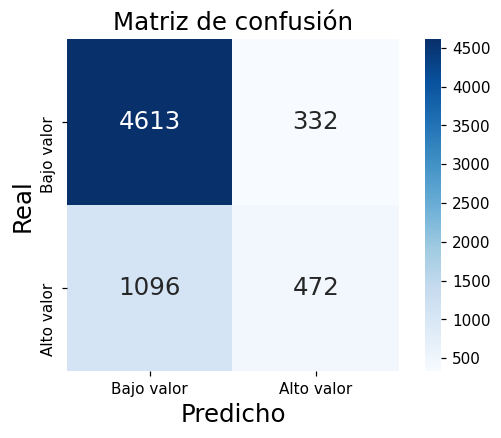

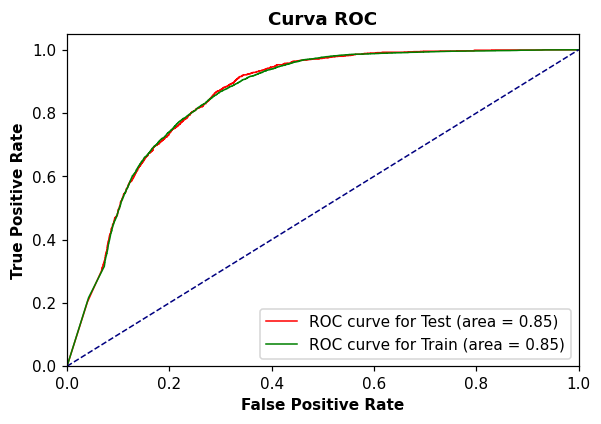

In [10]:
y_pred = model.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model, X_test, y_test, X_train, y_train)

Obtuvimos un AUC-ROC de 0.85 tanto para el set de train como para el set de test. Aún así, en otros modelos obtuvimos mejores valores y además la precision con respecto a las instancias de alto valor adquisitivo es bastante baja. Busquemos complejizar más la red

### Segundo diseño de la red

#### Diseño y entrenamiento

Para complejizar la red agregaremos más capas. Como la red se volverá más compleja utilizaremos relu como función de activación

In [11]:
seed(0)
tensorflow.random.set_seed(0)
# Sin esto, por alguna razón todos los modelos entrenados despues de otro se quedan en 0,5 AUC y muere la red, 
# seguramente te lo comente por audio por que lo sufri bastante

In [12]:
model = Sequential()
model.add(Dense(16,input_shape = (40,),activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1, activation="sigmoid"))

In [13]:
opt = tensorflow.keras.optimizers.SGD()
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['AUC','accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                656       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


Vemos que pasamos de alrededor de 100 params a 800. Finalmente, entrenamos nuestra red

In [14]:
history = model.fit(X_train.values, y_train,epochs=100,verbose=1,validation_data=(X_test.values, y_test))

Epoch 1/100
814/814 [==============================] - 1s 1ms/step - loss: 2.7978 - auc: 0.5132 - accuracy: 0.7431 - val_loss: 0.5308 - val_auc: 0.6194 - val_accuracy: 0.7593
Epoch 2/100
814/814 [==============================] - 1s 1ms/step - loss: 0.5255 - auc: 0.6169 - accuracy: 0.7607 - val_loss: 0.5099 - val_auc: 0.6823 - val_accuracy: 0.7591
Epoch 3/100
814/814 [==============================] - 1s 1ms/step - loss: 0.5070 - auc: 0.6890 - accuracy: 0.7622 - val_loss: 0.4888 - val_auc: 0.7753 - val_accuracy: 0.7593
Epoch 4/100
814/814 [==============================] - 1s 2ms/step - loss: 0.4976 - auc: 0.7145 - accuracy: 0.7614 - val_loss: 0.4662 - val_auc: 0.7853 - val_accuracy: 0.7593
Epoch 5/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4878 - auc: 0.7420 - accuracy: 0.7559 - val_loss: 0.4836 - val_auc: 0.7997 - val_accuracy: 0.7593
Epoch 6/100
814/814 [==============================] - 1s 1ms/step - loss: 0.4679 - auc: 0.7610 - accuracy: 0.7630 - val_loss

#### Métricas

Obtenemos las curvas de aprendizaje y demás metricas para establecer conclusiones

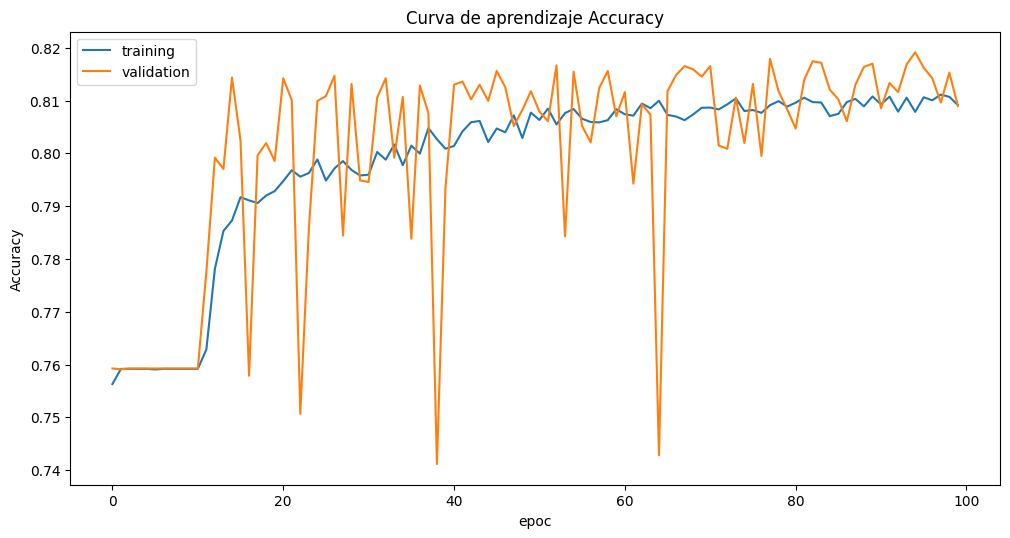

In [15]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.65,0.8,0.025))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

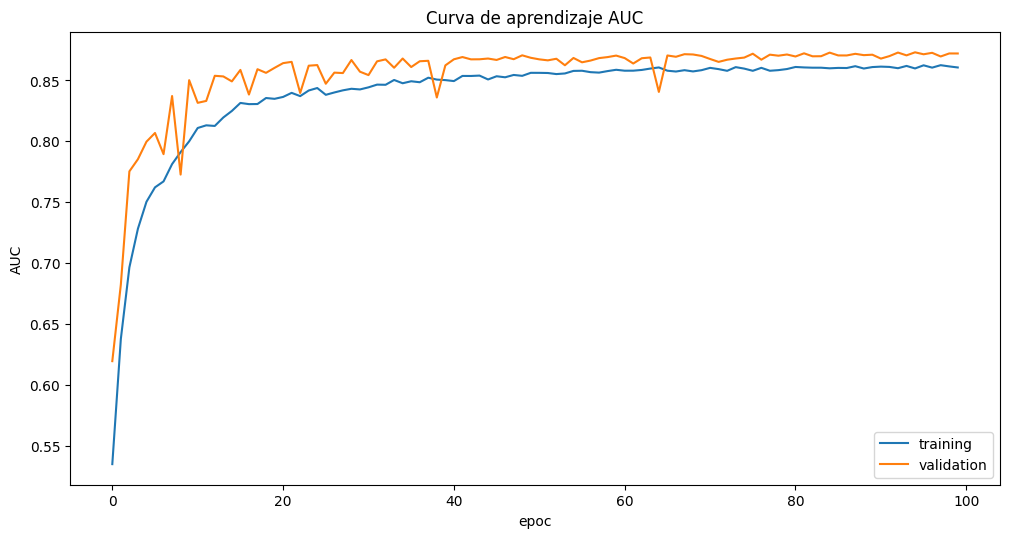

In [16]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

AUC-ROC score sobre test:  0.8722387590020841
AUC-ROC score sobre train:  0.8696085021532897
Accuracy sobre test:  0.8089973898357132
              precision    recall  f1-score   support

  Bajo valor       0.91      0.85      0.88      5311
  Alto valor       0.49      0.63      0.55      1202

    accuracy                           0.81      6513
   macro avg       0.70      0.74      0.71      6513
weighted avg       0.83      0.81      0.82      6513



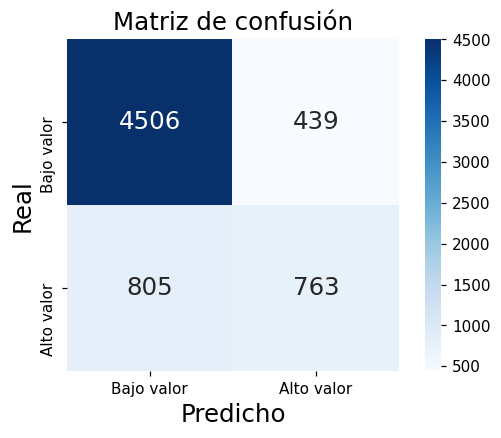

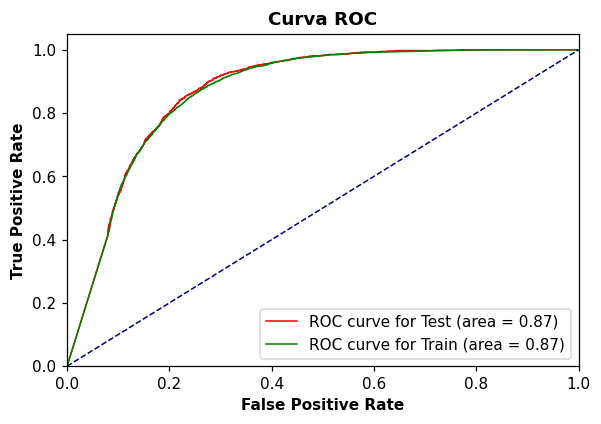

In [17]:
y_pred = model.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model, X_test, y_test, X_train, y_train)

Visualizando lo obtenido vemos una mejora interesante. No solo obtuvimos un mejor score de AUC-ROC sino que mejoro mucho la precision de la calse de altos ingresos. Aun así notamos algunos problemas en la cruva de aprendizaje de la metrica accuracy. Por lo que probaremos bajar el learning rate 

### Tercer diseño de la red

#### Diseño y entrenamiento

Realizaremos el mismo entrenamiento que antes pero bajando el learning rate

In [18]:
seed(0)
tensorflow.random.set_seed(0)
# Sin esto, por alguna razón todos los modelos entrenados despues de otro se quedan en 0,5 AUC y muere la red, 
# seguramente te lo comente por audio por que lo sufri bastante

In [19]:
model = Sequential()
model.add(Dense(16,input_shape = (40,),activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1, activation="sigmoid"))

Compilamos y mostramos un resumen de la red

In [20]:
opt = tensorflow.keras.optimizers.SGD(0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['AUC','accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                656       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train.values, y_train,epochs=350,verbose=1,validation_data=(X_test.values, y_test))


Epoch 1/350
814/814 [==============================] - 2s 2ms/step - loss: 3.2669 - auc: 0.5280 - accuracy: 0.5703 - val_loss: 0.5560 - val_auc: 0.5480 - val_accuracy: 0.7591
Epoch 2/350
814/814 [==============================] - 1s 1ms/step - loss: 0.5410 - auc: 0.5771 - accuracy: 0.7603 - val_loss: 0.5392 - val_auc: 0.5671 - val_accuracy: 0.7591
Epoch 3/350
814/814 [==============================] - 1s 1ms/step - loss: 0.5286 - auc: 0.5870 - accuracy: 0.7619 - val_loss: 0.5287 - val_auc: 0.5898 - val_accuracy: 0.7591
Epoch 4/350
814/814 [==============================] - 1s 2ms/step - loss: 0.5241 - auc: 0.6012 - accuracy: 0.7612 - val_loss: 0.5240 - val_auc: 0.6077 - val_accuracy: 0.7591
Epoch 5/350
814/814 [==============================] - 1s 1ms/step - loss: 0.5277 - auc: 0.6152 - accuracy: 0.7557 - val_loss: 0.5221 - val_auc: 0.6147 - val_accuracy: 0.7591
Epoch 6/350
814/814 [==============================] - 1s 1ms/step - loss: 0.5162 - auc: 0.6276 - accuracy: 0.7629 - val_loss

#### Métricas

Obtenemos las curvas de aprendizaje y demás metricas para establecer conclusiones

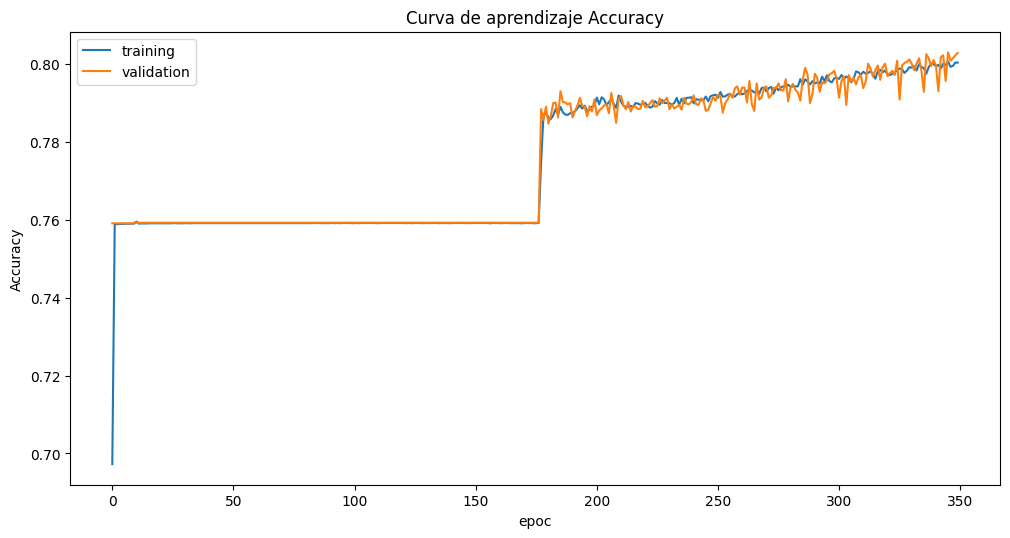

In [22]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.4,0.9,0.2))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

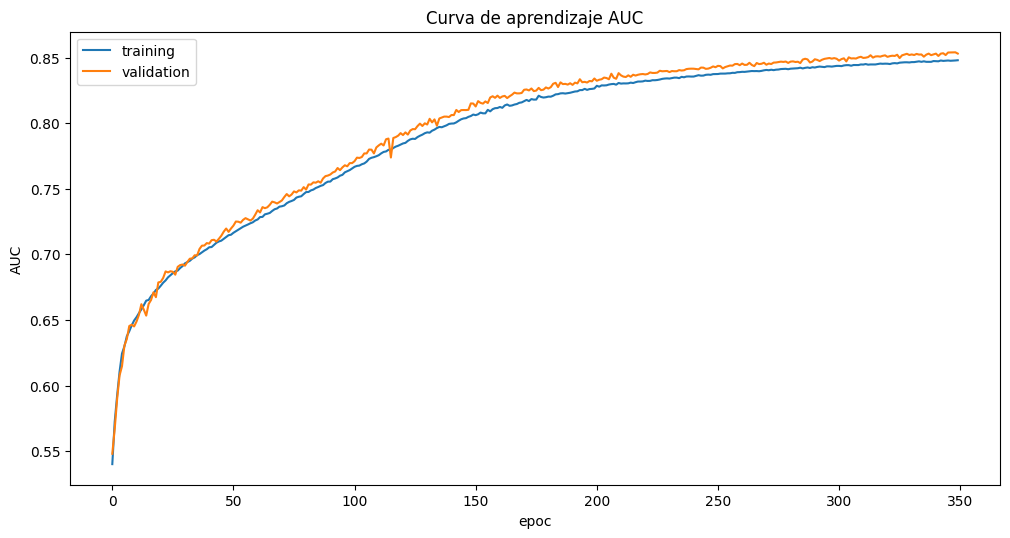

In [23]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

AUC-ROC score sobre test:  0.8528542281422176
AUC-ROC score sobre train:  0.8483672182449495
Accuracy sobre test:  0.8028558268079227
              precision    recall  f1-score   support

  Bajo valor       0.91      0.84      0.88      5335
  Alto valor       0.47      0.62      0.53      1178

    accuracy                           0.80      6513
   macro avg       0.69      0.73      0.70      6513
weighted avg       0.83      0.80      0.81      6513



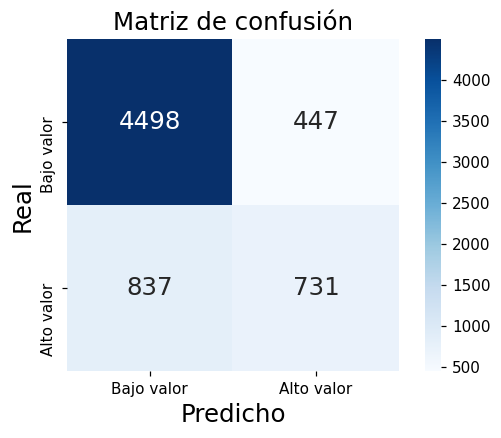

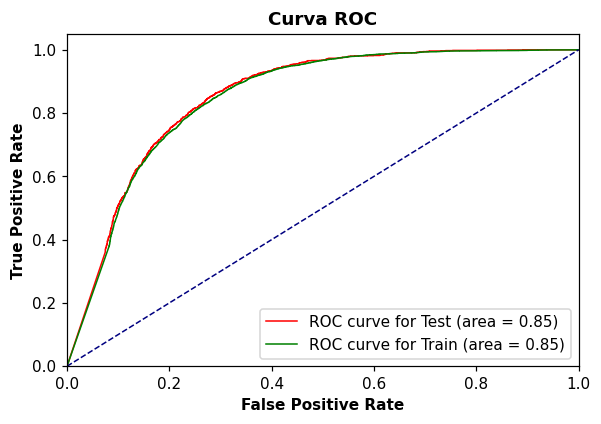

In [24]:
y_pred = model.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model, X_test, y_test, X_train, y_train)

Si bien se estabilizo un poco mas el entrenamiento, perdimos en metricas. Busquemos usar un mejor optimizador

### Cuarto entrenamiento

#### Diseño

Ahora cambiamos el optimizador por RMSprop, agregamos algo de regularización ya que sino corremos riesgo de overfittear

In [25]:
seed(0)
tensorflow.random.set_seed(0)
# Sin esto, por alguna razón todos los modelos entrenados despues de otro se quedan en 0,5 AUC y muere la red, 
# seguramente te lo comente por audio por que lo sufri bastante

In [26]:
model = Sequential()
model.add(Dense(16,input_shape = (40,),activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dense(8,activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dense(4,activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dense(1, activation="sigmoid"))

Compilamos y mostramos un resumen de la red

In [27]:
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['AUC','accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                656       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(X_train.values, y_train,epochs=200,verbose=1,validation_data=(X_test.values, y_test))

Epoch 1/200
814/814 [==============================] - 2s 2ms/step - loss: 4.2603 - auc: 0.5244 - accuracy: 0.3538 - val_loss: 0.5725 - val_auc: 0.6612 - val_accuracy: 0.7777
Epoch 2/200
814/814 [==============================] - 2s 2ms/step - loss: 0.5125 - auc: 0.7287 - accuracy: 0.7936 - val_loss: 0.4975 - val_auc: 0.8027 - val_accuracy: 0.7927
Epoch 3/200
814/814 [==============================] - 2s 2ms/step - loss: 0.4676 - auc: 0.8049 - accuracy: 0.7963 - val_loss: 0.4607 - val_auc: 0.8283 - val_accuracy: 0.7952
Epoch 4/200
814/814 [==============================] - 2s 2ms/step - loss: 0.4373 - auc: 0.8290 - accuracy: 0.8023 - val_loss: 0.4404 - val_auc: 0.8477 - val_accuracy: 0.7990
Epoch 5/200
814/814 [==============================] - 2s 2ms/step - loss: 0.4392 - auc: 0.8427 - accuracy: 0.7999 - val_loss: 0.4247 - val_auc: 0.8581 - val_accuracy: 0.8013
Epoch 6/200
814/814 [==============================] - 2s 3ms/step - loss: 0.4191 - auc: 0.8537 - accuracy: 0.8140 - val_loss

#### Métricas

Obtenemos las curvas de aprendizaje y demás metricas para establecer conclusiones

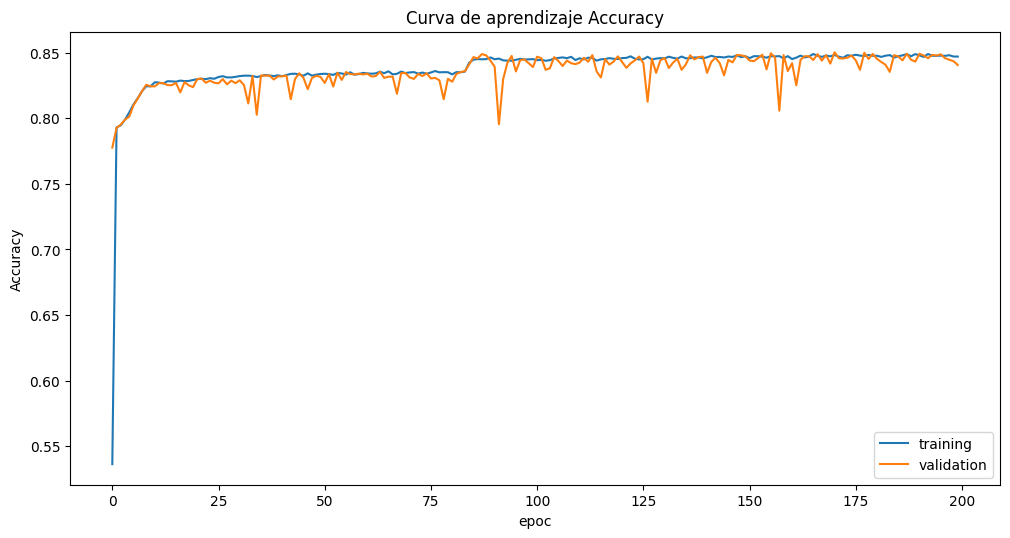

In [29]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.65,0.8,0.025))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

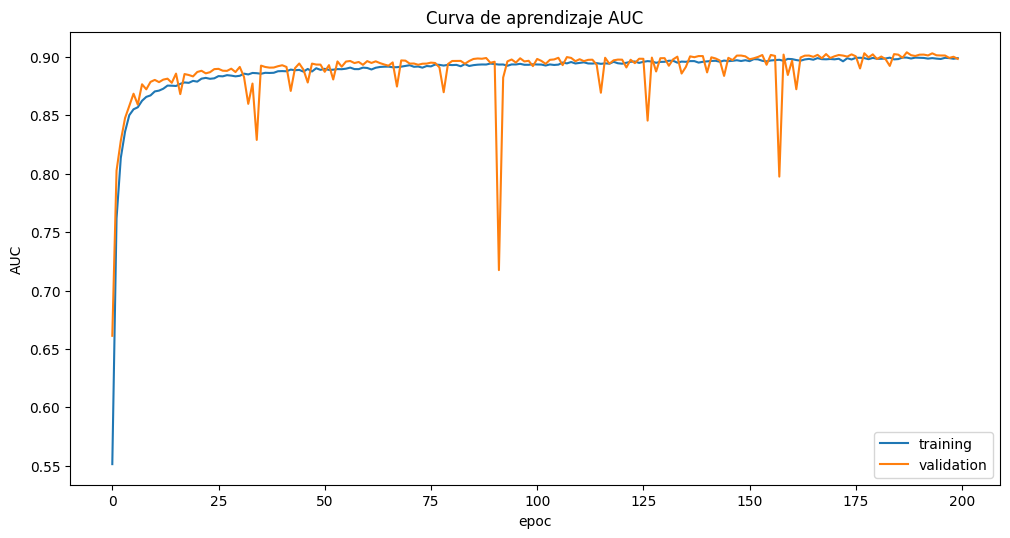

In [30]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

AUC-ROC score sobre test:  0.8984583608468667
AUC-ROC score sobre train:  0.8994050838552559
Accuracy sobre test:  0.8406264394288346
              precision    recall  f1-score   support

  Bajo valor       0.91      0.88      0.90      5135
  Alto valor       0.61      0.69      0.65      1378

    accuracy                           0.84      6513
   macro avg       0.76      0.79      0.77      6513
weighted avg       0.85      0.84      0.84      6513



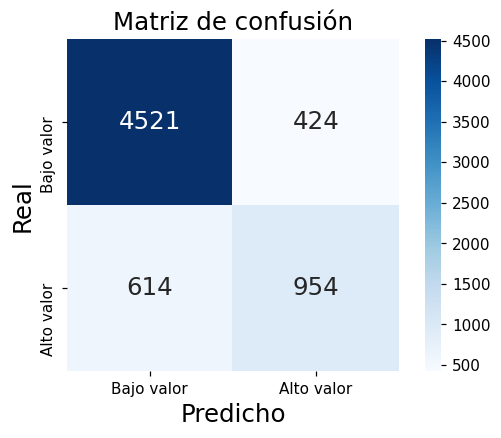

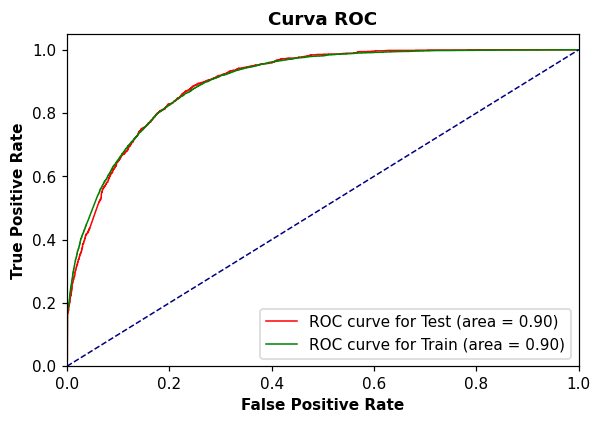

In [31]:
y_pred = model.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model, X_test, y_test, X_train, y_train)

Observamos que mejoro considerablemente el AUC-ROC. También se observan mejoras significativas en la medición de precision y recall de la clase con altos ingresos

### Quinto entrenamiento

#### Diseño

Ahora agrandamos la red y agregamos droput como metodo de regularización

In [8]:
seed(0)
tensorflow.random.set_seed(0)
# Sin esto, por alguna razón todos los modelos entrenados despues de otro se quedan en 0,5 AUC y muere la red, 
# seguramente te lo comente por audio por que lo sufri bastante

In [9]:
model = Sequential()
model.add(Dense(16,input_shape = (40,),activation='relu', kernel_regularizer=l2(0.0001)))
#model.add(Dropout(0.25))
model.add(Dense(16,activation='relu', kernel_regularizer=l2(0.0001)))
#model.add(Dropout(0.25))
model.add(Dense(8,activation='relu', kernel_regularizer=l2(0.0001)))
#model.add(Dropout(0.25))
model.add(Dense(8,activation='relu', kernel_regularizer=l2(0.0001)))
#model.add(Dropout(0.25))
model.add(Dense(4,activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dense(1, activation="sigmoid"))

Compilamos y mostramos un resumen de la red

In [10]:

opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['AUC','accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                656       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 1,177
Trainable params: 1,177
Non-trainable params: 0
____________________________________________________

Tenemos 1200 params, mientrás que anteriormente teniamos aproximadamente 800

In [11]:
mc = ModelCheckpoint('mejor_modelo', monitor='val_acc', mode='max') # Guardo el mejor modelo
history = model.fit(X_train.values, y_train,epochs=200,verbose=1,validation_data=(X_test.values, y_test),callbacks=[mc])

Epoch 1/200
814/814 [==============================] - 2s 2ms/step - loss: 0.6052 - auc: 0.4635 - accuracy: 0.7051 - val_loss: 0.5471 - val_auc: 0.4556 - val_accuracy: 0.7591
INFO:tensorflow:Assets written to: mejor_modelo/assets
Epoch 2/200
814/814 [==============================] - 1s 1ms/step - loss: 0.5366 - auc: 0.4957 - accuracy: 0.7607 - val_loss: 0.5226 - val_auc: 0.6044 - val_accuracy: 0.7593
INFO:tensorflow:Assets written to: mejor_modelo/assets
Epoch 3/200
814/814 [==============================] - 1s 1ms/step - loss: 0.5121 - auc: 0.6545 - accuracy: 0.7622 - val_loss: 0.4972 - val_auc: 0.7484 - val_accuracy: 0.7593
INFO:tensorflow:Assets written to: mejor_modelo/assets
Epoch 4/200
814/814 [==============================] - 1s 1ms/step - loss: 0.4903 - auc: 0.7559 - accuracy: 0.7614 - val_loss: 0.4734 - val_auc: 0.7963 - val_accuracy: 0.7593
INFO:tensorflow:Assets written to: mejor_modelo/assets
Epoch 5/200
814/814 [==============================] - 1s 1ms/step - loss: 0.472

#### Métricas

Obtenemos las curvas de aprendizaje y demás metricas para establecer conclusiones

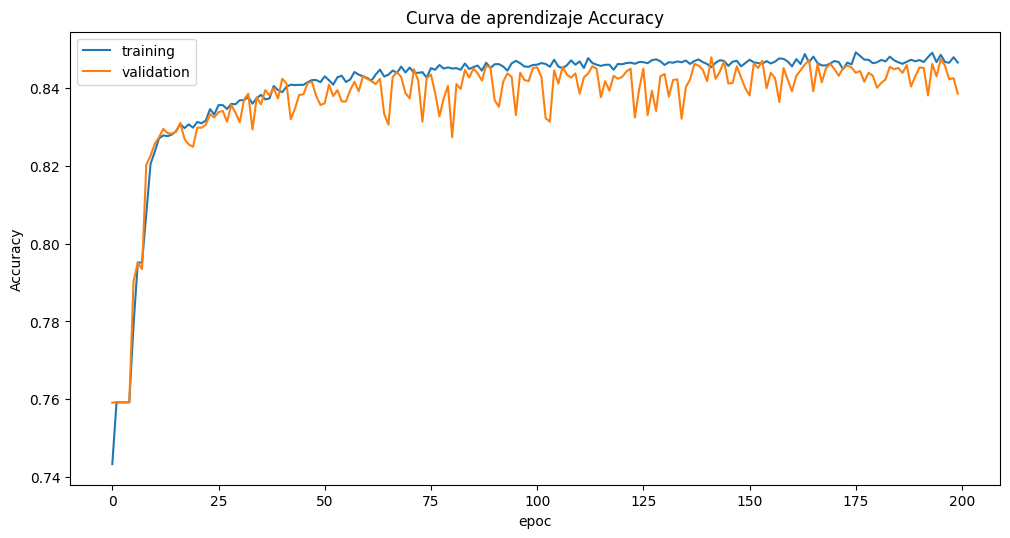

In [12]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.65,0.8,0.025))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

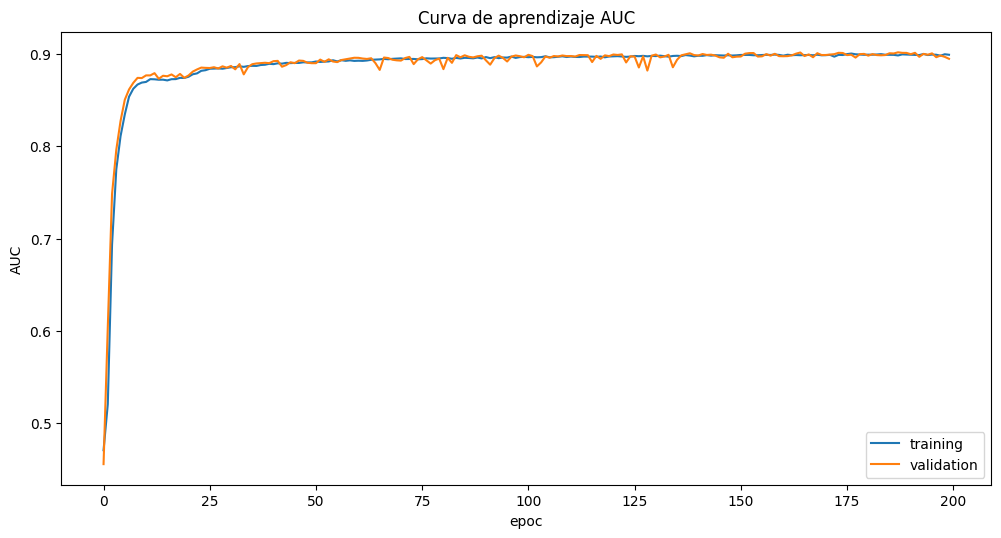

In [13]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

AUC-ROC score sobre test:  0.8948784847609419
AUC-ROC score sobre train:  0.8951712746397933
Accuracy sobre test:  0.8386304314448026
              precision    recall  f1-score   support

  Bajo valor       0.91      0.88      0.89      5060
  Alto valor       0.63      0.68      0.65      1453

    accuracy                           0.84      6513
   macro avg       0.77      0.78      0.77      6513
weighted avg       0.84      0.84      0.84      6513



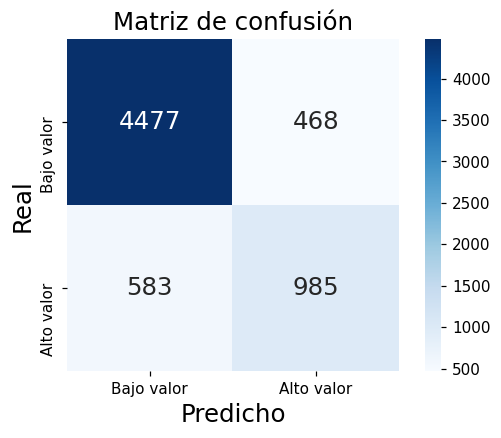

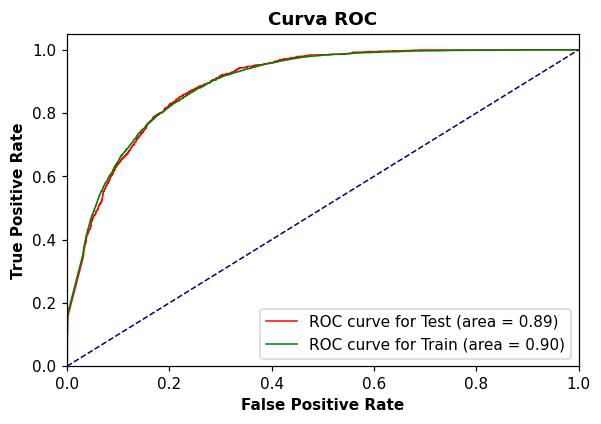

In [14]:
y_pred = model.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model, X_test, y_test, X_train, y_train)

Observamos que mejoro levement el AUC-ROC. También mejoro levemente la precision en la clase de altos ingresos. Si bien probamos redes mas grandes, por lo general no causaron mejoras y por el contrario, empezaba a overfittearse el entrenamiento. Asi que el modelo final sera este donde aún conseguimos mejorar sin overfittear

Aca me falta agregar codigo para quedarme con el mejor

## Segundo preprocesamiento

Volveremos a entrenar una red, pero en este caso realizaremos otro preprocesamiento a nuestros datos. Volvemos a cargar el dataset

In [5]:
df, df_holdout = obtener_datasets()

Realizamos nuesttro nuevo preprocesado. En este caso se trata de una modificación mas leve a nuestras features en donde no agruparemos como lo hicimos en el primer preprocesado (por ejemplo en la educación). Además, tendremos en cuenta a la feature barrio, generalizando entre los residente en Palermo y los no residentes en Palermo

In [6]:
X_df, y_df = aplicar_preparacion_generalizado(df)
X_df = conversion_numerica_generalizada(X_df) 

Aplicando 'conversion_numerica_generalizada' en las variables categóricas.


Observemos cuantas features tenemos

In [7]:
X_df.shape

(32561, 43)

Luego vamos a realizar un split del dataset para dividir en train y test. Como observamos en la primer parte de este trabajo práctico, la variable target no esta distribuida uniformente por lo cual realizamos una división estratificada

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=30,stratify=y_df)

In [9]:
from numpy.random import seed
seed(0)
import tensorflow.random
tensorflow.random.set_seed(0)


### Primer diseño de la red

Como ya fuimos de menos a más en el anterior preprocesado, comenzemos con una red algo más compleja. Usaremos función de activación relu en las capas, optimizador SGD (learning rate 0.01) y obviamente sigmoidea como función de activación en la última capa

In [10]:
seed(0)
tensorflow.random.set_seed(0)
# Sin esto, por alguna razón todos los modelos entrenados despues de otro se quedan en 0,5 AUC y muere la red, 
# seguramente te lo comente por audio por que lo sufri bastante

In [11]:
model_2 = Sequential()
model_2.add(Dense(16,input_shape = (43,),activation='relu'))
model_2.add(Dense(8,activation='relu'))
model_2.add(Dense(4,activation='relu'))
model_2.add(Dense(1, activation="sigmoid"))

Vemos un resumen de nuestra red

In [12]:
opt = tensorflow.keras.optimizers.SGD(lr=0.001)
model_2.compile(loss='binary_crossentropy', optimizer=opt,metrics=['AUC','accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


Finalmente entrenamos

In [13]:
history = model_2.fit(X_train.values, y_train,epochs=200,verbose=1,validation_data=(X_test.values, y_test))

Epoch 1/200
814/814 [==============================] - 1s 1ms/step - loss: 2.4946 - auc: 0.5357 - accuracy: 0.7074 - val_loss: 0.5429 - val_auc: 0.5307 - val_accuracy: 0.7588
Epoch 2/200
814/814 [==============================] - 1s 992us/step - loss: 0.5349 - auc: 0.5528 - accuracy: 0.7602 - val_loss: 0.5352 - val_auc: 0.5561 - val_accuracy: 0.7589
Epoch 3/200
814/814 [==============================] - 1s 933us/step - loss: 0.5290 - auc: 0.5733 - accuracy: 0.7621 - val_loss: 0.5302 - val_auc: 0.5746 - val_accuracy: 0.7593
Epoch 4/200
814/814 [==============================] - 1s 871us/step - loss: 0.5267 - auc: 0.5860 - accuracy: 0.7614 - val_loss: 0.5263 - val_auc: 0.5965 - val_accuracy: 0.7593
Epoch 5/200
814/814 [==============================] - 1s 894us/step - loss: 0.5286 - auc: 0.6159 - accuracy: 0.7559 - val_loss: 0.5207 - val_auc: 0.6208 - val_accuracy: 0.7593
Epoch 6/200
814/814 [==============================] - 1s 1ms/step - loss: 0.5135 - auc: 0.6425 - accuracy: 0.7630 - 

#### Métricas

Obtenemos las curvas de aprendizaje y demás metricas para establecer conclusiones

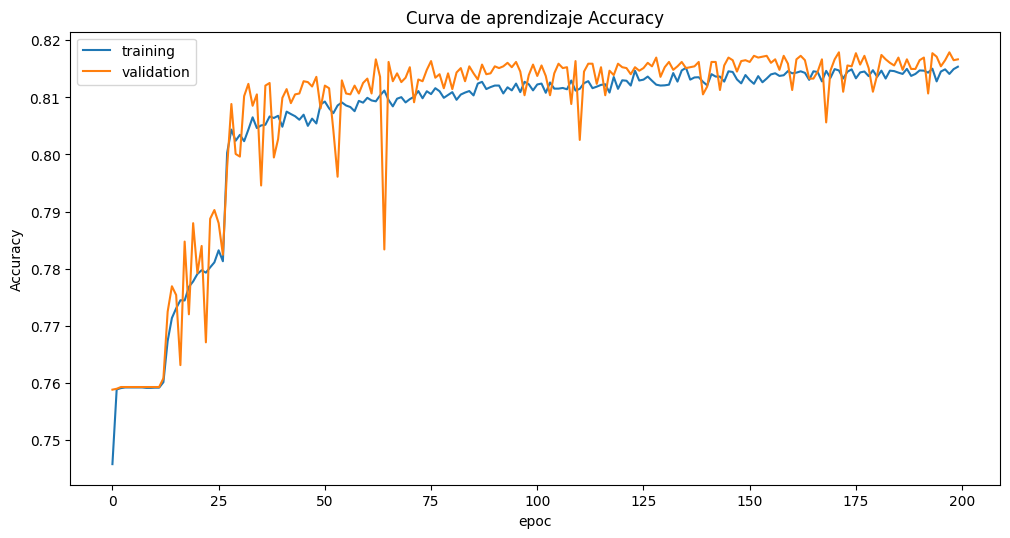

In [14]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.65,0.8,0.025))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

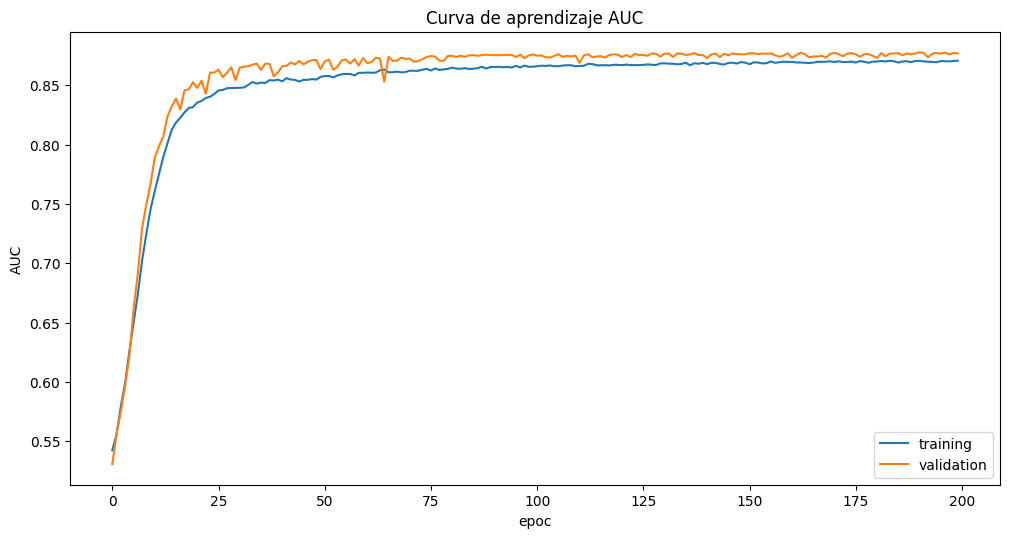

In [15]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

AUC-ROC score sobre test:  0.8770771212934112
AUC-ROC score sobre train:  0.8746117599496810
Accuracy sobre test:  0.8166743436204514
              precision    recall  f1-score   support

  Bajo valor       0.87      0.89      0.88      4845
  Alto valor       0.65      0.61      0.63      1668

    accuracy                           0.82      6513
   macro avg       0.76      0.75      0.75      6513
weighted avg       0.81      0.82      0.81      6513



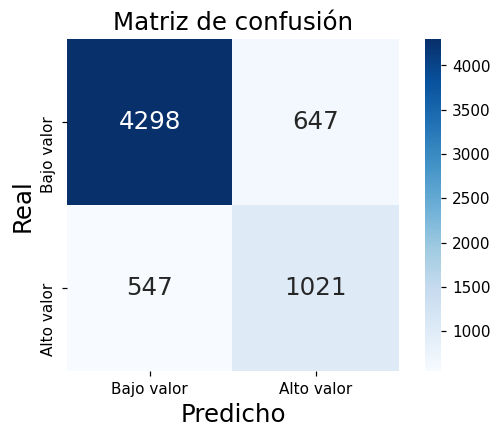

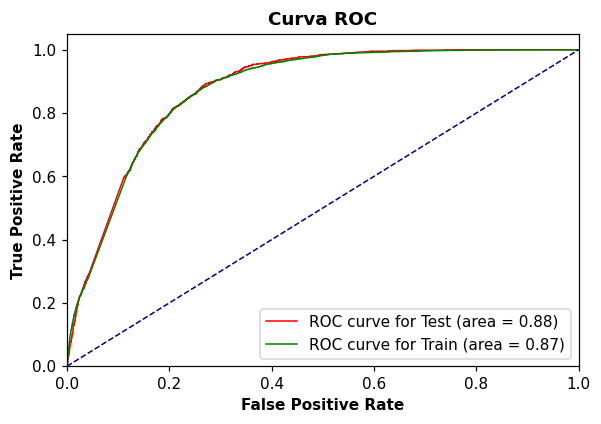

In [16]:
y_pred = model_2.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model_2.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model_2.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model_2, X_test, y_test, X_train, y_train)

Los resultados no son nada malos. Aún así, el apredizaje parece estar erratico con lo cual podemos probar bajando el learning rate. Además, probemos el optimizador RMSprop

### Segundo diseño de la red

Seguiremos con la misma estrucctura pero modificando el learnin rate a 0.0001 y cambiando el optimziador

In [46]:
seed(0)
tensorflow.random.set_seed(0)
# Sin esto, por alguna razón todos los modelos entrenados despues de otro se quedan en 0,5 AUC y muere la red, 
# seguramente te lo comente por audio por que lo sufri bastante

In [47]:
model_2 = Sequential()
model_2.add(Dense(16,input_shape = (43,),activation='relu'))
model_2.add(Dense(8,activation='relu'))
model_2.add(Dense(4,activation='relu'))
model_2.add(Dense(1, activation="sigmoid"))

Vemos un resumen de nuestra red

In [48]:
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001)
model_2.compile(loss='binary_crossentropy', optimizer=opt,metrics=['AUC','accuracy'])
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 16)                704       
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


Finalmente entrenamos

In [49]:
history = model_2.fit(X_train.values, y_train,epochs=200,verbose=1,validation_data=(X_test.values, y_test))

Epoch 1/200
814/814 [==============================] - 2s 1ms/step - loss: 3.6835 - auc: 0.5359 - accuracy: 0.3925 - val_loss: 0.5685 - val_auc: 0.6513 - val_accuracy: 0.7746
Epoch 2/200
814/814 [==============================] - 1s 1ms/step - loss: 0.5178 - auc: 0.6979 - accuracy: 0.7914 - val_loss: 0.5019 - val_auc: 0.7821 - val_accuracy: 0.7920
Epoch 3/200
814/814 [==============================] - 1s 1ms/step - loss: 0.4698 - auc: 0.7922 - accuracy: 0.7963 - val_loss: 0.4553 - val_auc: 0.8262 - val_accuracy: 0.7963
Epoch 4/200
814/814 [==============================] - 1s 1ms/step - loss: 0.4329 - auc: 0.8308 - accuracy: 0.8020 - val_loss: 0.4319 - val_auc: 0.8489 - val_accuracy: 0.7989
Epoch 5/200
814/814 [==============================] - 1s 1ms/step - loss: 0.4310 - auc: 0.8466 - accuracy: 0.8052 - val_loss: 0.4137 - val_auc: 0.8613 - val_accuracy: 0.8105
Epoch 6/200
814/814 [==============================] - 1s 1ms/step - loss: 0.4074 - auc: 0.8585 - accuracy: 0.8196 - val_loss

#### Métricas

Obtenemos las curvas de aprendizaje y demás metricas para establecer conclusiones

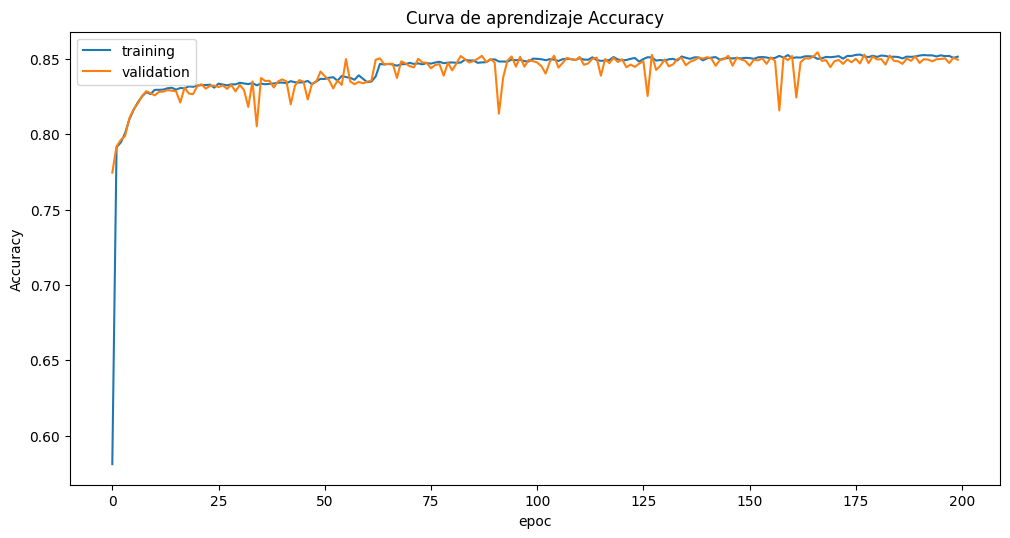

In [50]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.65,0.8,0.025))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

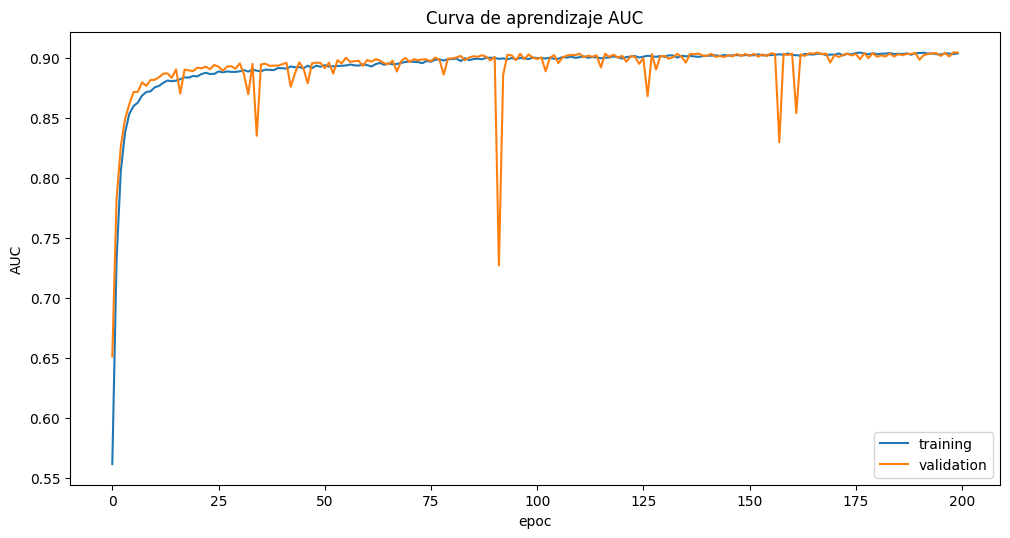

In [51]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

AUC-ROC score sobre test:  0.9044047662037515
AUC-ROC score sobre train:  0.9086439525806725
Accuracy sobre test:  0.8495317058191310
              precision    recall  f1-score   support

  Bajo valor       0.93      0.88      0.90      5241
  Alto valor       0.59      0.73      0.65      1272

    accuracy                           0.85      6513
   macro avg       0.76      0.80      0.78      6513
weighted avg       0.86      0.85      0.86      6513



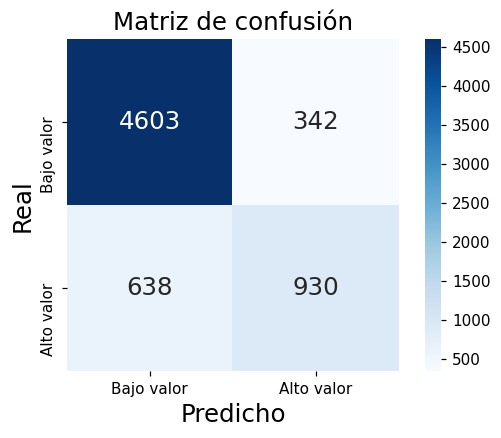

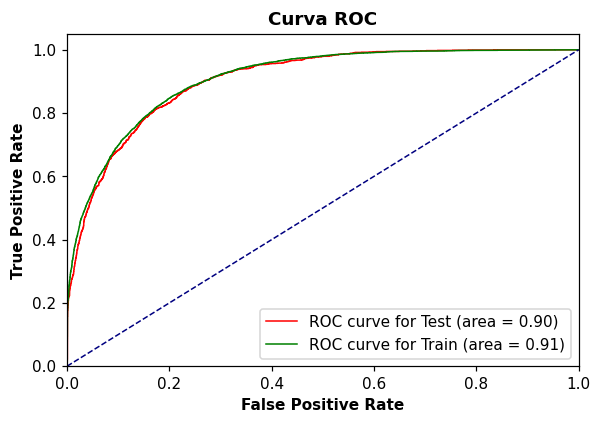

In [52]:
y_pred = model_2.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model_2.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model_2.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model_2, X_test, y_test, X_train, y_train)

Observamos un incrememento importante en la métrica AUC-ROC. También subió bastante el recall en la clase de altos ingresos, aunque bajo la precision. Parece haberse logrado el objetivo de estabilizar la curva de aprendizaje

### Tercer diseño de la red

Buscaremos agrandar la red para ver si obtenemos mejores resultados. Como corremos riesgo de overfittear, utilizaremos técnicas para prevenirlo

In [70]:
seed(0)
tensorflow.random.set_seed(0)
# Sin esto, por alguna razón todos los modelos entrenados despues de otro se quedan en 0,5 AUC y muere la red, 
# seguramente te lo comente por audio por que lo sufri bastante

In [71]:
model_2 = Sequential()
model_2.add(Dense(32,input_shape = (43,),activation='relu',kernel_regularizer=l1(0.0001)))
#model_2.add(Dropout(0.25))
model_2.add(Dense(16,activation='relu',kernel_regularizer=l1(0.0001)))
#model_2.add(Dropout(0.25))
model_2.add(Dense(16,activation='relu',kernel_regularizer=l1(0.0001)))
model_2.add(Dense(8,activation='relu',kernel_regularizer=l1(0.0001)))
model_2.add(Dense(1, activation="sigmoid"))

Vemos un resumen de nuestra red

In [72]:
opt = tensorflow.keras.optimizers.RMSprop(lr=0.00001)
model_2.compile(loss='binary_crossentropy', optimizer=opt,metrics=['AUC','accuracy'])
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 32)                1408      
_________________________________________________________________
dense_42 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_43 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


Finalmente entrenamos

In [73]:
history = model_2.fit(X_train.values, y_train,epochs=400,verbose=1,validation_data=(X_test.values, y_test))

Epoch 1/400
814/814 [==============================] - 2s 1ms/step - loss: 2.4744 - auc: 0.4609 - accuracy: 0.7528 - val_loss: 1.6790 - val_auc: 0.4196 - val_accuracy: 0.7737
Epoch 2/400
814/814 [==============================] - 1s 1ms/step - loss: 1.3499 - auc: 0.4502 - accuracy: 0.7842 - val_loss: 0.7111 - val_auc: 0.4186 - val_accuracy: 0.7817
Epoch 3/400
814/814 [==============================] - 1s 1ms/step - loss: 0.6614 - auc: 0.4335 - accuracy: 0.7897 - val_loss: 0.5864 - val_auc: 0.4659 - val_accuracy: 0.7855
Epoch 4/400
814/814 [==============================] - 1s 1ms/step - loss: 0.5666 - auc: 0.5047 - accuracy: 0.7916 - val_loss: 0.5696 - val_auc: 0.5022 - val_accuracy: 0.7872
Epoch 5/400
814/814 [==============================] - 1s 1ms/step - loss: 0.5671 - auc: 0.5110 - accuracy: 0.7871 - val_loss: 0.5619 - val_auc: 0.5146 - val_accuracy: 0.7860
Epoch 6/400
814/814 [==============================] - 1s 1ms/step - loss: 0.5488 - auc: 0.5356 - accuracy: 0.7945 - val_loss

#### Métricas

Obtenemos las curvas de aprendizaje y demás metricas para establecer conclusiones

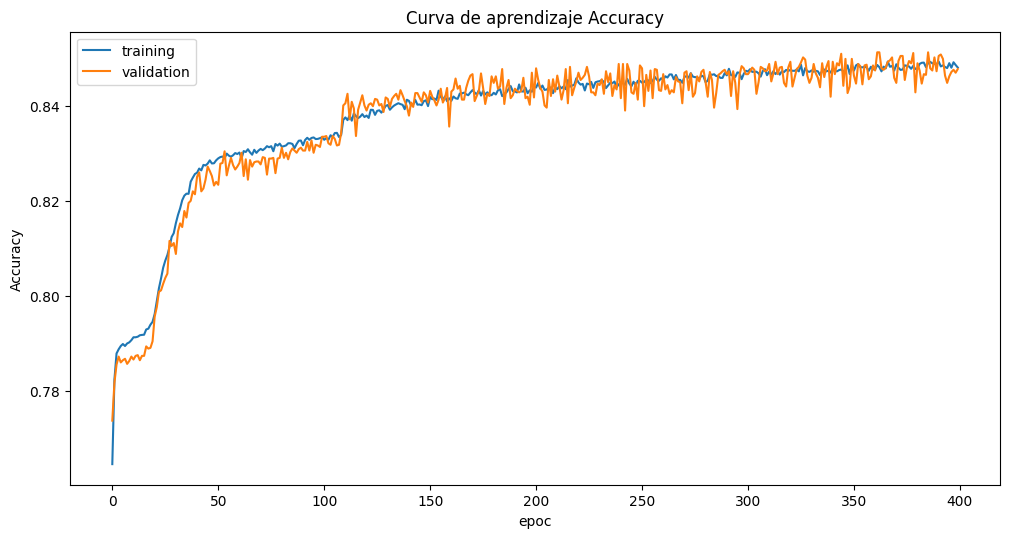

In [74]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("Accuracy")
plt.xlabel("epoc")
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
#plt.yticks(np.arange(0.65,0.8,0.025))
plt.title("Curva de aprendizaje Accuracy")
plt.legend()
plt.show()

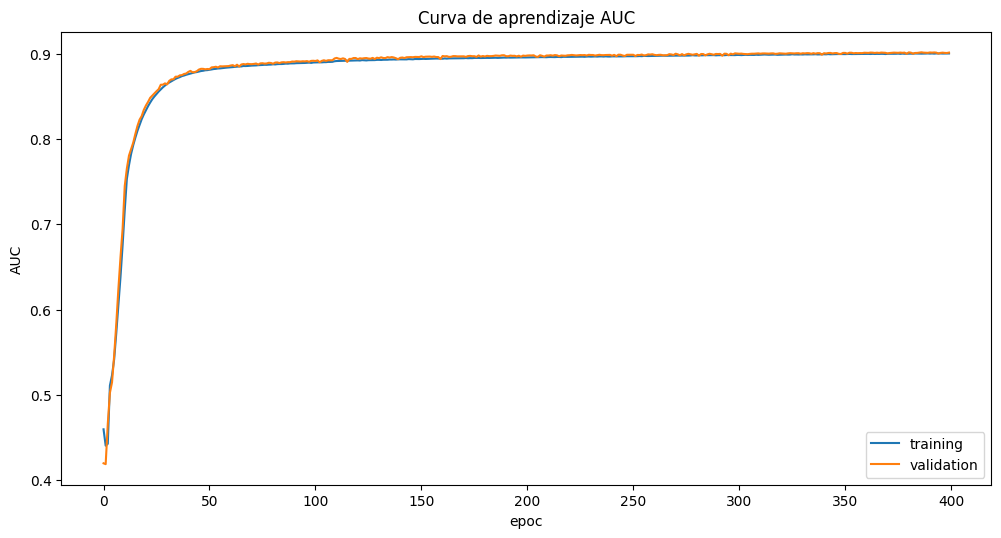

In [75]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.ylabel("AUC")
plt.xlabel("epoc")
plt.plot(history.history["auc"], label="training")
plt.plot(history.history["val_auc"], label="validation")
plt.title("Curva de aprendizaje AUC")
plt.legend()
plt.show()

AUC-ROC score sobre test:  0.9014994015806524
AUC-ROC score sobre train:  0.9009597127576838
Accuracy sobre test:  0.8478427759864886
              precision    recall  f1-score   support

  Bajo valor       0.92      0.88      0.90      5180
  Alto valor       0.61      0.72      0.66      1333

    accuracy                           0.85      6513
   macro avg       0.77      0.80      0.78      6513
weighted avg       0.86      0.85      0.85      6513



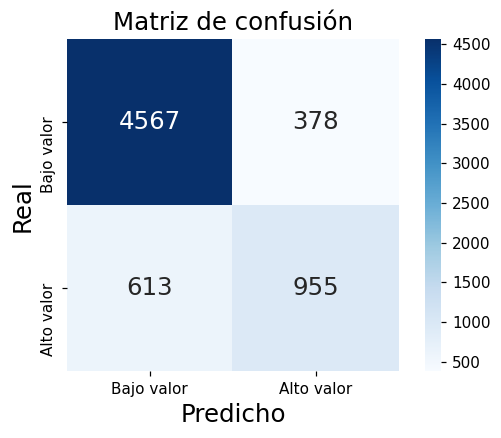

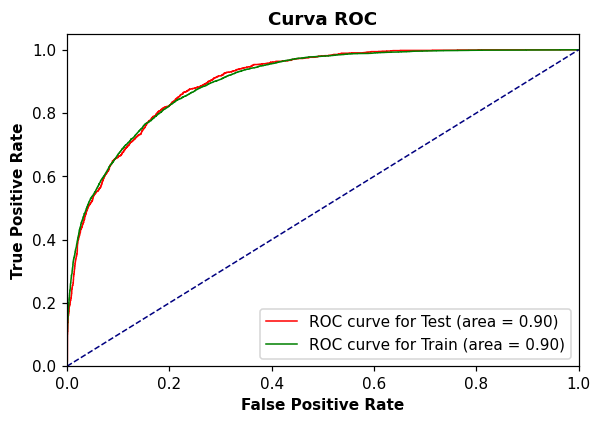

In [76]:
y_pred = model_2.predict(X_test).round()
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, model_2.predict(X_test)))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, model_2.predict(X_train)))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves_red(model_2, X_test, y_test, X_train, y_train)

Observamos un incrememento importante en la métrica AUC-ROC. También subió bastante el recall en la clase de altos ingresos, aunque bajo la precision. Parece haberse logrado el objetivo de estabilizar la curva de aprendizaje